In [1]:
#library
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

#pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

#시드 고정
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Data
##### 수기로 작성된 0 데이터. 데이터는 [여기](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits)에서 다운 가능

In [2]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

##### pytorch의 DataLoader 인스턴스를 만들어주자

In [4]:
image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="./datasets/optdigits.tra", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

##### 데이터 시각화

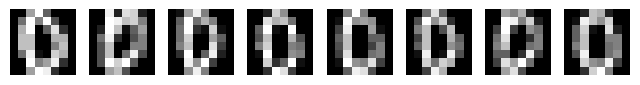

In [5]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

### Discriminator(판별자) 생성
##### Discriminator는 2개의 Hidden Layer로 구성된 Fully Connected Layer로 구성합니다. Discriminator는 Classical한 Neural Network입니다. Discriminator의 Output은 Input이 실제 데이터인지를 나타내는 확률입니다.

In [6]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

### Generator(생성자) 구현

##### 각각의 보조 생성자(sub-generator), $G^{(i)}$는 아래의 그림처럼 회로 구성을 가집니다. 전반적인 양자 생성자는 $N_{G}$개의 보조 생성자로 구성되며, 각각은 $N$개의 큐비트들로 이루어져 있습니다. 잠재 벡터(latent vector)입력에서 이미지 출력까지의 프로세스는 4개의 특징적인 세션으로 구분 할 수 있습니다: state embedding, parametrisation, non-linear transformation, 그리고 post-processing. 각각의 섹션들은 간단하게 하기 위해 한 훈련 과정의 한번의 반복을 나타냅니다.

##### 1) State Embedding
##### 잠재 벡터, $z \in \mathbb{R}^{N}$는 $\left[ 0, \pi/2 \right)$범위의 uniform distribution에서 샘플링됩니다. 모든 보조 생성자는 RY게이트를 통해 Angle임베딩된 같은 잠재 벡터를 받습니다.

##### 2) Parameterized Layers
##### parameterized layer는 RY게이트와 Z게이트로 이루어져 있습니다. 이 레이어는 총 $D$번 반복됩니다.